 # PAOO6: Marketing strategy for bank customers

## Planejamento da solução (IoT)

### Input

1. Business case
    * Customer segmentation
2. Data set
    * the last six months with approximately 9k customers active credit card.
        - There are 18 columns.

### Output

1. Data Analysis


2. Reports with the answers to busisness questions

    1. Create a customer segmentation based on clear selection criteria.
        - RMF
    2. Make customer segmentation accessible to the operations team.
        - Dashboard
        - Streamlit
        - Metabase
    3. Teach the operations team how to use your solution.
    4. Transfer knowledge to International Bank Data Scientists.
    5. Recommend 2-3 business levers for each customer segment.

3. Machine learning algorithm available in an API


### Tasks

- Data Description 
    - Replace NA
.
- EDA

    - Univariate Analisys.
    - Bivariate Analisys.
    - Multivariate Analisys.
    - Check outlier
    - Space study
    - Embedding definition
.
- ML Training

    - Performance analysis.
    - Cluster analysis.
    - The definition of the cluster numbers.
.
- EDA Insights Analysis
    - Explanation about segmentations' features.
    - Cloud architecture with diagrams(https://diagrams.mingrammer.com/docs/getting-started/examples)
        - AWS architecture.
         - S3 store data 
         - EC2 store ETL and visualization tools.
         - DB 
         - Cronjob analysis
         - Papermill


- CUSTID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases (
- BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFFPURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTSPURCHASES : Amount of purchase done in installment
- CASHADVANCE : Cash in advance given by the user
- PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASESTRX : Numbe of purchase transactions made
- CREDITLIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

# 0.0 IMPORTS

In [19]:
import pandas as pd 
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML
import inflection
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats               import chi2_contingency,shapiro

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()


def descriptive_statistics(df1_num):

    """
    Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    # Central Tendency - mean, meadina
    ct1= pd.DataFrame(df1_num.apply(np.mean)).T
    ct2= pd.DataFrame(df1_num.apply(np.median)).T

    # dispersion - std, min, max, range, skew, kurtosis
    ct3= pd.DataFrame(df1_num.apply(np.std)).T
    ct4= pd.DataFrame(df1_num.apply(min)).T
    ct5= pd.DataFrame(df1_num.apply(max)).T
    ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
    ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
    ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
    ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T


    # concatenar
    df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8, ct9]).T
    df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
    df_statistics.round(2)

    return df_statistics


Populating the interactive namespace from numpy and matplotlib


# 0.2 Loadind dataset

In [4]:
df_raw=pd.read_csv('/home/tc0019/DS/bank_marketing/data/raw/CC_GENERAL.csv')
df_raw.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# 1.0 Data Description

In [5]:
df1=df_raw.copy()

## 1.1 Rename columns

In [6]:
df1.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [7]:
cols_old=['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

df1.columns=cols_new

df1.sample()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
1775,C11835,2286.9003,0.909091,4536.48,3275.0,1261.48,0.0,1.0,0.333333,1.0,0.0,0,37,4000.0,5981.014712,1542.926815,0.0,12


## 1.2. Data Dimensions

In [10]:
rows_,columns_=df1.shape

print(f'Number of Rows: {rows_} \nNumber of Cols: {columns_}')

Number of Rows: 8950 
Number of Cols: 18


## 1.3. Data Types

In [11]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

### 1.4.1 Remove NA

In [13]:
df1 = df1.dropna(subset=['credit_limit', 'minimum_payments'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))

Removed data: 0.04


In [14]:
df1.isna().sum()


cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [15]:
df1.shape

(8636, 18)

## 1.5. Descriptive Statistics

In [25]:
df1_num=df1.select_dtypes(include=['int64', 'float64']).round(2)
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### 1.5.1. Numerical Atributes

In [26]:
descriptive_statistics(df1_num)

,min,max,range,mean,median,std,skew,kurtosis,shapiro
balance,0.0,19043.14,19043.14,1601.224885,916.855,2095.449946,2.374254,7.553877,not normal
balance_frequency,0.0,1.0,1.0,0.895212,1.0,0.207915,-2.095833,3.420292,not normal
purchases,0.0,49039.57,49039.57,1025.433874,375.405,2166.982511,8.055789,108.677684,not normal
oneoff_purchases,0.0,40761.25,40761.25,604.901438,44.995,1684.210284,9.935776,160.121308,not normal
installments_purchases,0.0,22500.0,22500.0,420.843533,94.785,917.192075,7.216133,94.193373,not normal
cash_advance,0.0,47137.21,47137.21,994.175518,0.0,2121.335471,5.139629,52.143521,not normal
purchases_frequency,0.0,1.0,1.0,0.495884,0.5,0.401547,0.033127,-1.638517,not normal
oneoff_purchases_frequency,0.0,1.0,1.0,0.20564,0.08,0.300262,1.505065,1.059185,not normal
purchases_installments_frequency,0.0,1.0,1.0,0.368951,0.17,0.398244,0.487376,-1.41975,not normal
cash_advance_frequency,0.0,1.5,1.5,0.137373,0.0,0.20192,1.797457,3.187502,not normal


# 2.0 Feature Engineering

In [27]:
df2=df1.copy()

In [31]:
df2.head().round(2)

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,cred_tenure
0,C10001,40.90,0.82,95.40,0.00,95.40,0.00,0.17,0.00,0.08,0.00,0,2,1000.0,201.80,139.51,0.00,12,83.33
1,C10002,3202.47,0.91,0.00,0.00,0.00,6442.95,0.00,0.00,0.00,0.25,4,0,7000.0,4103.03,1072.34,0.22,12,583.33
2,C10003,2495.15,1.00,773.17,773.17,0.00,0.00,1.00,1.00,0.00,0.00,0,12,7500.0,622.07,627.28,0.00,12,625.00
4,C10005,817.71,1.00,16.00,16.00,0.00,0.00,0.08,0.08,0.00,0.00,0,1,1200.0,678.33,244.79,0.00,12,100.00
5,C10006,1809.83,1.00,1333.28,0.00,1333.28,0.00,0.67,0.00,0.58,0.00,0,8,1800.0,1400.06,2407.25,0.00,12,150.00


In [30]:
# credit_limit by tenure
df2['cred_tenure']=df2['credit_limit']/df2['tenure']

# 3.0 Data Filtering

In [37]:
df3=df2.copy()

# 4.0 EDA

In [39]:
df4=df3.copy()


# 5.0 Data preparation

In [40]:
df5=df4.copy()


# 6.0 Feature Selection

In [41]:
df6=df5.copy()


# 7.0 Hyperparameter fine tuning

In [49]:
df7=df6.copy()
X = df6.drop(columns='cust_id')
clusters = [2, 3, 4, 5, 6]

## 7.1 Within-Cluster Sum of Square (WSS)

Text(0.5, 1.0, 'WSS vs K')

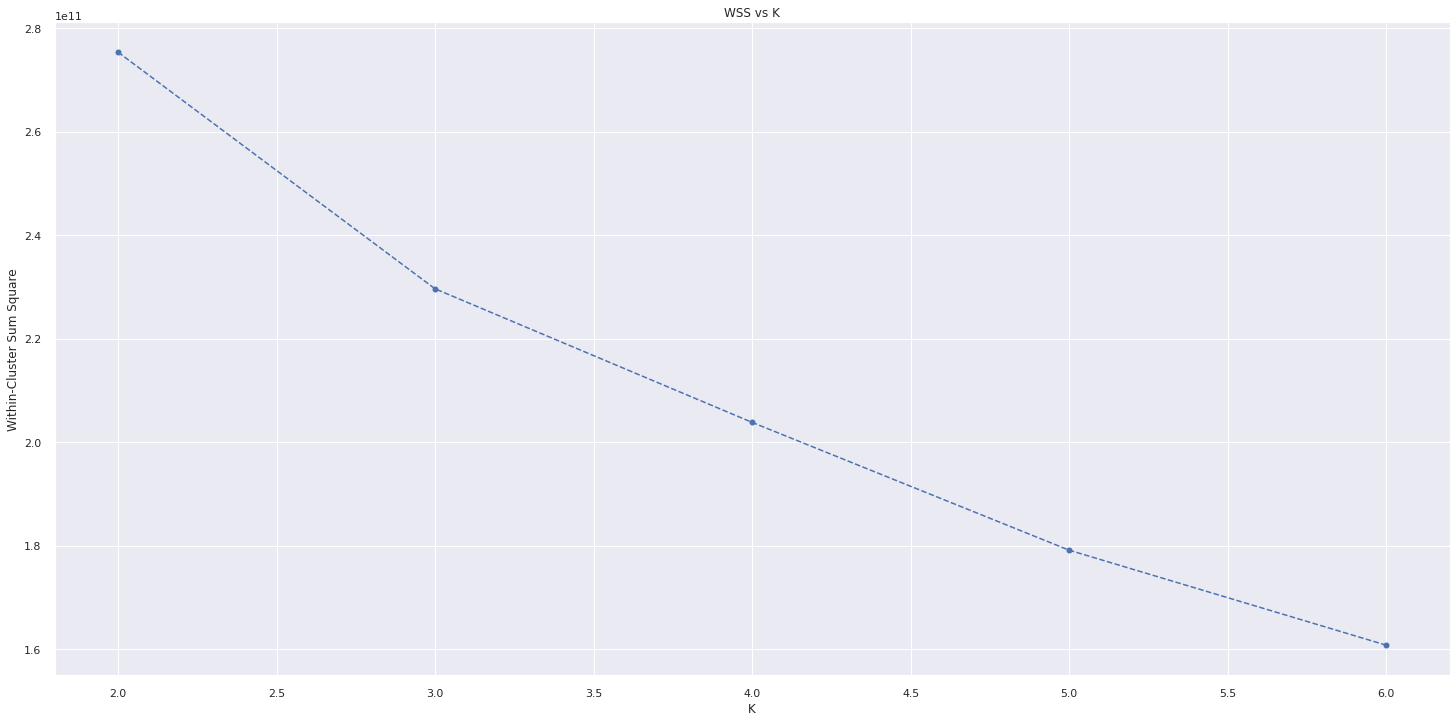

In [50]:
wss = []
for k in clusters:
    # model definition
    kmeans=c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

    # model Training
    kmeans.fit(X)

    # validation
    wss.append( kmeans.inertia_)

# plot wss elbow method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum Square');
plt.title('WSS vs K');

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


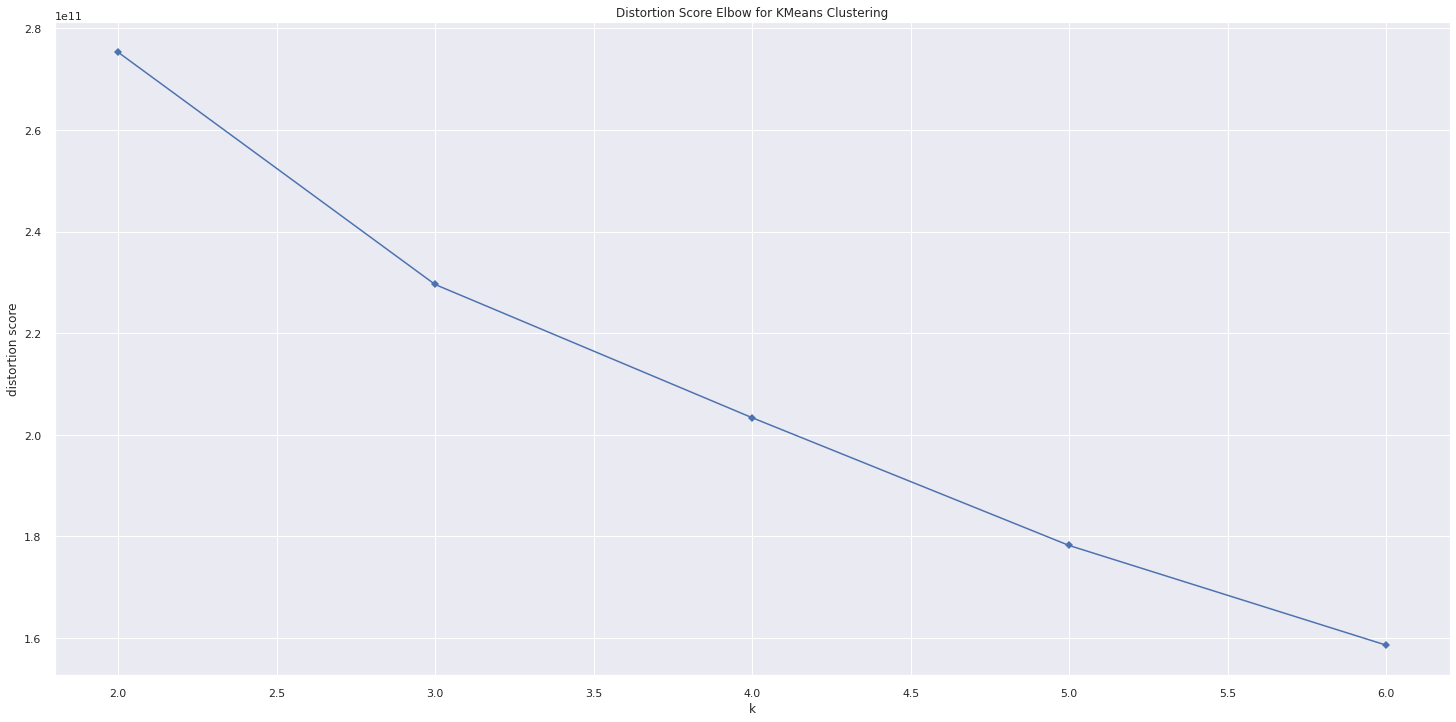

In [52]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False );
kmeans.fit(X)
kmeans.show();

## 7.2 Sillhouette Score

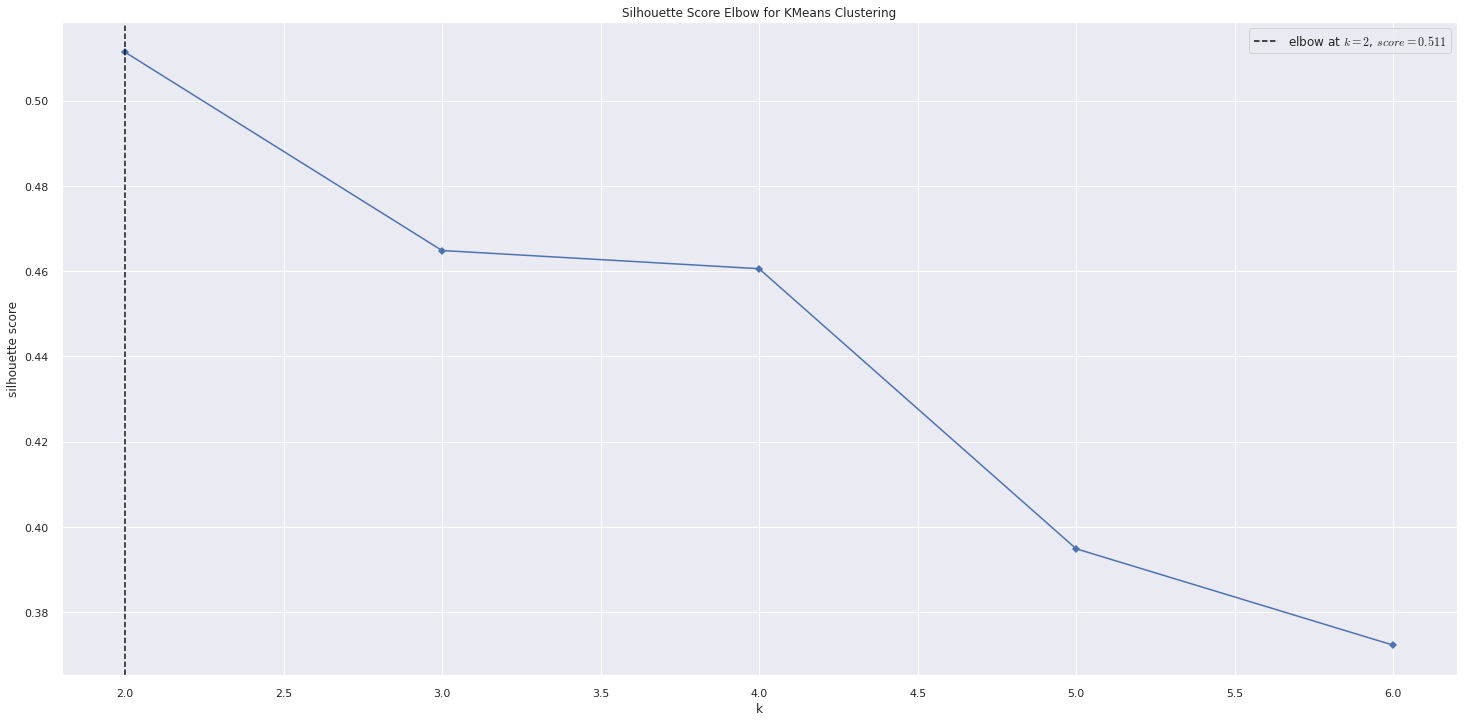

In [53]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

# 8.0 Model Training

In [52]:
df8=df7.copy()


# 9.0 Cluster Analysis

In [53]:
df9=df8.copy()


# 10.0 Deploy to production

In [54]:
df10=df9.copy()
